# **TAREA 2 - MACHINE LEARNING 2**
### **Assignment 2: Principal Component Analysis, Neural Networks**

**Integrantes:**

* Llaro Castro, Diego Renato
* Rios Meza, Jennifer Saskia
* Vargas Flores, Johanna Antonella

## **Part I: Eigenfaces for Face Recognition**
## **1. Load the Training and Test Sets**

In [1]:
# IMPORTAMOS LIBRERÍAS
import os
import numpy as np
import imageio
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm

In [2]:
# RUTA BASE DE IMÁGENES
base_path = '/workspaces/TAREA2_ML2_LLARO_RIOS_VARGAS/data/images'

# LEEMOS TRAIN Y TEST CSV/TXT

train_csv = pd.read_csv(
    '/workspaces/TAREA2_ML2_LLARO_RIOS_VARGAS/data/train.txt',
    sep=r'\s+',      # UNO O MÁS ESPACIOS COMO SEPARADOR
    header=None,     # EL ARCHIVO NO TIENE CABECERA
    usecols=[0,1],   # LEEMOS SOLO LAS DOS PRIMERAS COLUMNAS
    names=["image", "label"],
    engine='python'
).dropna()           # ELIMINAMOS FILAS VACÍAS

test_csv = pd.read_csv(
    '/workspaces/TAREA2_ML2_LLARO_RIOS_VARGAS/data/test.txt',
    sep=r'\s+',
    header=None,
    usecols=[0,1],
    names=["image", "label"],
    engine='python'
).dropna()

In [3]:
# CARGAMOS DATOS DE ENTRENAMIENTO
train_data, train_labels = [], []

for idx, row in train_csv.iterrows():
    img_name = str(row['image']).strip()       # QUITAR ESPACIOS
    label = int(row['label'])                  # CONVERTIR ETIQUETA A ENTERO
    img_path = os.path.join(base_path, os.path.basename(img_name))  # RUTA COMPLETA

    # VERIFICAMOS QUE EL ARCHIVO EXISTE
    if not os.path.exists(img_path):
        print(f"Archivo no encontrado: {img_path}")
        continue

    # LEEMOS LA IMAGEN Y LA APLANAMOS A 2500 DIMENSIONES
    im = imageio.v2.imread(img_path)
    train_data.append(im.reshape(2500,))
    train_labels.append(label)

train_data = np.array(train_data, dtype=float)
train_labels = np.array(train_labels, dtype=int)

print("IMÁGENES DE ENTRENAMIENTO CARGADAS:", len(train_data))


IMÁGENES DE ENTRENAMIENTO CARGADAS: 540


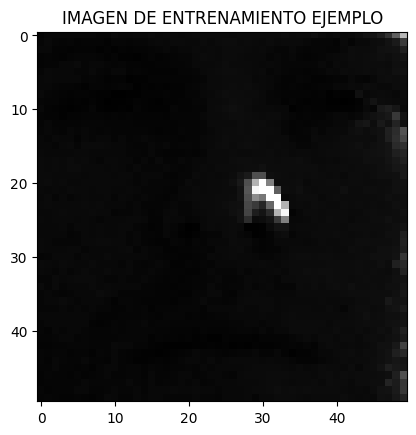

In [4]:
# MOSTRAMOS UNA IMAGEN DE EJEMPLO
if len(train_data) > 0:
    plt.imshow(train_data[0].reshape(50,50), cmap=cm.Greys_r)
    plt.title("IMAGEN DE ENTRENAMIENTO EJEMPLO")
    plt.show()
else:
    print("No se cargó ninguna imagen de entrenamiento.")

IMÁGENES DE PRUEBA CARGADAS: 100


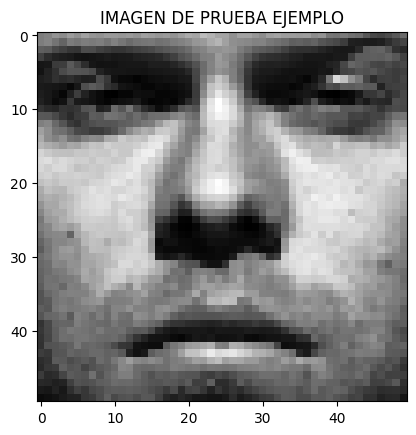

In [ ]:
# CARGAMOS LAS IMÁGENES DE PRUEBA
test_data, test_labels = [], []

for idx, row in test_csv.iterrows():
    img_name = str(row['image']).strip()
    label = int(row['label'])
    img_path = os.path.join(base_path, os.path.basename(img_name))

    if not os.path.exists(img_path):
        print(f"Archivo no encontrado: {img_path}")
        continue

    im = imageio.v2.imread(img_path)
    test_data.append(im.reshape(2500,))
    test_labels.append(label)

test_data = np.array(test_data, dtype=float)
test_labels = np.array(test_labels, dtype=int)

print("IMÁGENES DE PRUEBA CARGADAS:", len(test_data))

if len(test_data) > 0:
    plt.imshow(test_data[0].reshape(50,50), cmap=cm.Greys_r)
    plt.title("IMAGEN DE PRUEBA EJEMPLO")
    plt.show()
else:
    print("No se cargó ninguna imagen de prueba.")

## **2. Average Face**

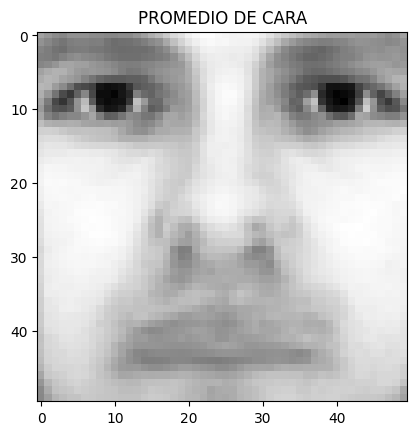

In [7]:
# COMPUTAMOS EL VECTOR PROMEDIO μ SUMANDO TODAS LAS FILAS DE train_data Y DIVIDIENDO ENTRE EL NÚMERO DE FILAS
mu = np.mean(train_data, axis=0)

# MOSTRAMOS EL PROMEDIO DE CARA COMO IMAGEN EN ESCALA DE GRISES
plt.imshow(mu.reshape(50,50), cmap=cm.Greys_r)
plt.title("PROMEDIO DE CARA")
plt.show()

## **3. Mean Subtraction**

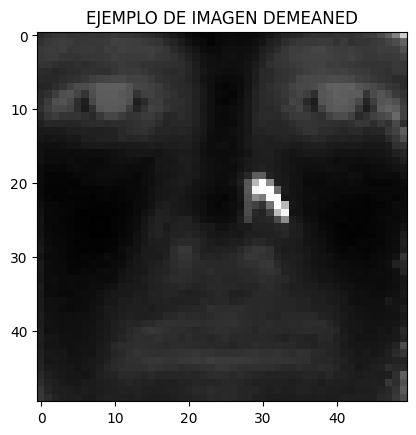

In [9]:
# CREAMOS UNA COPIA DEMEANED DE train_data
X_demeaned = train_data - mu  # CADA FILA RESTA μ

# MOSTRAMOS UN EJEMPLO DE IMAGEN DEMEANED
plt.imshow(X_demeaned[0].reshape(50,50), cmap=cm.Greys_r)
plt.title("EJEMPLO DE IMAGEN DEMEANED")
plt.show()

In [10]:
# APLICAMOS LA MISMA RESTA DE PROMEDIO AL CONJUNTO DE PRUEBA
X_test_demeaned = test_data - mu

## **4. Eigenfaces**

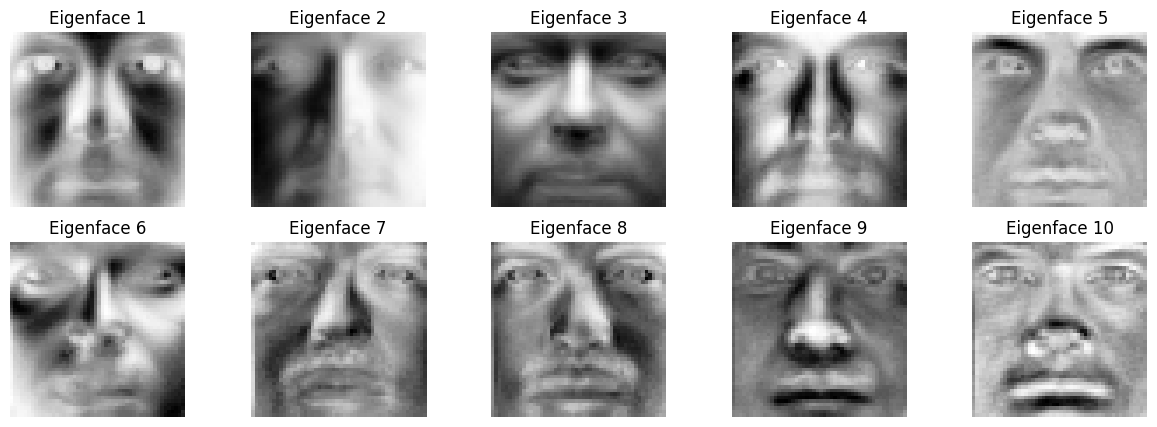

In [11]:
# MÉTODO CLÁSICO: CALCULAMOS LA MATRIZ DE COVARIANZA
# COV = X^T X
cov_matrix = np.dot(X_demeaned.T, X_demeaned)  # FORMA: 2500 x 2500

# EIGENDECOMPOSICIÓN: OBTENEMOS EIGENVECTORES (V) Y EIGENVALORES (Λ)
eigvals, eigvecs = np.linalg.eigh(cov_matrix)  # eigh es para matrices simétricas

# ORDENAMOS LOS EIGENVECTORES SEGÚN EIGENVALORES DESCENDENTES
idx = np.argsort(eigvals)[::-1]  # ÍNDICES DE MAYOR A MENOR
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# LAS FILAS DE V^T SON LOS EIGENFACES
eigenfaces = eigvecs.T  # FORMA: num_eigenfaces x 2500

# CONVERTIMOS A REAL (POR SI HAY COMPLEJOS)
eigenfaces = np.real(eigenfaces)

# MOSTRAMOS LAS PRIMERAS 10 EIGENFACES
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(eigenfaces[i].reshape(50,50), cmap=cm.Greys_r)
    plt.title(f"Eigenface {i+1}")
    plt.axis('off')
plt.show()

## **5. Eigenface Features**

In [12]:
def compute_eigenface_features(X, eigenfaces, r):
    """
    COMPUTA LA MATRIZ DE CARACTERÍSTICAS USANDO LOS TOP r EIGENFACES
    INPUTS:
        X           : matriz de datos (num_imágenes x 2500) DEMEANED
        eigenfaces  : matriz de eigenfaces (num_eigenfaces x 2500)
        r           : número de eigenfaces a usar
    OUTPUTS:
        F           : matriz de características (num_imágenes x r)
    """
    top_r_eigenfaces = eigenfaces[:r]  # TOMAMOS LAS PRIMERAS r FILAS
    F = np.dot(X, top_r_eigenfaces.T)  # MULTIPLICACIÓN: X * V_r^T
    return F

In [13]:
# EJEMPLO: USANDO r = 10
r = 10
F_train = compute_eigenface_features(X_demeaned, eigenfaces, r)
F_test  = compute_eigenface_features(X_test_demeaned, eigenfaces, r)

print("SHAPE DE MATRIZ DE CARACTERÍSTICAS TRAIN:", F_train.shape)
print("SHAPE DE MATRIZ DE CARACTERÍSTICAS TEST:", F_test.shape)

SHAPE DE MATRIZ DE CARACTERÍSTICAS TRAIN: (540, 10)
SHAPE DE MATRIZ DE CARACTERÍSTICAS TEST: (100, 10)


## **6. Face Recognition**

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# ENTRENAMOS REGRESIÓN LOGÍSTICA CON r = 10
clf = LogisticRegression(fit_intercept=False, max_iter=1000, solver='lbfgs', multi_class='auto')
clf.fit(F_train, train_labels)

# PREDICCIÓN EN TEST
y_pred = clf.predict(F_test)

# ACCURACY EN EL CONJUNTO DE PRUEBA
accuracy = accuracy_score(test_labels, y_pred)
print(f"ACCURACY CON r = 10 EIGENFACES: {accuracy:.4f}")

ACCURACY CON r = 10 EIGENFACES: 0.7600


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
# BARRIDO DE r = 1 A 200 PARA VER EFECTO EN LA ACCURACY
r_values = list(range(1, 201))
accuracies = []

for r in r_values:
    F_train_r = compute_eigenface_features(X_demeaned, eigenfaces, r)
    F_test_r  = compute_eigenface_features(X_test_demeaned, eigenfaces, r)
    
    clf = LogisticRegression(fit_intercept=False, max_iter=1000, solver='lbfgs', multi_class='auto')
    clf.fit(F_train_r, train_labels)
    y_pred_r = clf.predict(F_test_r)
    acc_r = accuracy_score(test_labels, y_pred_r)
    accuracies.append(acc_r)